In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image Segmentation on Vertex AI


<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/image_editing_maskmode.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fvision%2Fgetting-started%2Fimage_editing_maskmode.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/vision/getting-started/image_editing_maskmode.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/vision/getting-started/image_editing_maskmode.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

| | |
|-|-|
|Author | [Jorj Ismailyan](https://github.com/jismailyan-google) |

## Overview

Vertex Image Segmentation brings Google's state of the art segmentation models to developers as a scalable and reliable service.

With Image Segmentation, developers can choose from five different modes to segment images and build AI products, including with a **text prompt** and **interactive** mode.

Learn more about [Image Segmentation on Vertex](https://docs.google.com/document/d/1y5H_m29zGM3Xt6ba2lMw_di6bpbvtQagpU-xY30Kx78/edit?resourcekey=0-_-4WVkfl0oS3nfBwIEhWWQ&tab=t.0).


### Objectives

In this notebook, you will be exploring the features of Vertex Image Segmentation using the Vertex AI Python SDK. You will

- Segment the foreground or background of an object
  - Create a product image by removing the background
  - Change the background color of an image
- Control the generated mask by configuring dilation
- Use an open-vocabulary text prompt to perform:
  - Object detection
  - Instance segmentation
- Draw a scribble to guide segmentation
  - Perform point-to-mask segmentation

### Costs

- This notebook uses billable components of Google Cloud:
  - Vertex AI

- Learn about [Vertex AI pricing](https://cloud.google.com/vertex-ai/pricing) and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## Getting Started

### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the following cell to authenticate your environment. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud project information and initialize Vertex AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and enable the Vertex AI API.

Learn more about setting up a project and a development environment.

In [ ]:
from google.cloud import aiplatform
from google.cloud.aiplatform.gapic import PredictResponse

PROJECT_ID = "<your-project-id-here>"  # @param {type:"string"}
LOCATION = "us-central1"  # @param ["asia-northeast1", "asia-northeast3", "asia-southeast1", "europe-west1", "europe-west2", "europe-west3", "europe-west4", "europe-west9", "northamerica-northeast1", "us-central1", "us-east4", "us-west1", "us-west4"]

aiplatform.init(project=PROJECT_ID, location=LOCATION)

api_regional_endpoint = f"{LOCATION}-aiplatform.googleapis.com"
client_options = {"api_endpoint": api_regional_endpoint}
client = aiplatform.gapic.PredictionServiceClient(client_options=client_options)

model_endpoint = f"projects/{PROJECT_ID}/locations/{LOCATION}/publishers/google/models/image-segmentation-001"
print(f"Prediction client initiated on project {PROJECT_ID} in {LOCATION}.")

In [ ]:
# @title Import libraries
# @markdown Run this cell before proceeding to import libraries and define utility functions.
import io
import random
import timeit
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from google.protobuf.struct_pb2 import Value
from IPython.display import display
from PIL import Image, ImageDraw, ImageFont


# Parses the generated mask bytes from the response prediction and converts it
# to an Image PIL object.
def prediction_to_mask_pil(prediction: Value) -> Image:
    encoded_mask_string = prediction["bytesBase64Encoded"]
    mask_bytes = base64.b64decode(encoded_mask_string)
    mask_pil = Image.open(io.BytesIO(mask_bytes))
    mask_pil.thumbnail((640, 640))
    return mask_pil


# Extracts masks from the response and overlays them onto the base image.
def overlay(input_image: Image, response: PredictResponse) -> Image:
    # Make the original image colors grayscale so the overlayed masks are easier to see
    overlayed_image = INPUT_IMAGE_PIL.copy().convert("L").convert("RGB")

    for prediction in response.predictions:
        mask_pil = prediction_to_mask_pil(prediction)

        # Gives the mask a distinct color and makes the background transparent
        color = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
            128,
        )
        colored_mask = Image.new("RGBA", mask_pil.size, color)
        colored_mask = Image.composite(
            colored_mask, Image.new("RGBA", mask_pil.size), mask_pil
        )

        # Pastes the colored mask onto the result image
        overlayed_image.paste(colored_mask, (0, 0), colored_mask)

    return overlayed_image


# Displays a PIL image horizontally next to a generated mask from the response.
def display_horizontally(
    input_images: List, mask_index: int = -1, figsize: Tuple[int, int] = (15, 15)
):
    count = len(input_images)
    fig, ax = plt.subplots(1, count, figsize=figsize)

    for i in range(count):
        cmap = "gray" if i == mask_index else None
        ax[i].imshow(input_images[i], cmap)
        ax[i].axis("off")

    plt.show()


# Generates a transparent PNG image from an input image and its generated mask.
def generate_transparent_image(image_pil: str, mask_pil: Image) -> Image:
    transparent_image = Image.new("RGBA", image_pil.size, (128, 128, 128, 255))

    transparent_image.paste(image_pil, mask=mask_pil)
    transparent_image.putalpha(mask_pil)
    return transparent_image


def draw_bounding_boxes(base_image: Image, response: PredictResponse):
    bbox_image = base_image.copy()
    labeled_boxes = get_labeled_boxes(response)
    color = "red"
    draw = ImageDraw.Draw(bbox_image)
    for box in labeled_boxes:
        bounding_box = box[2]
        draw.rectangle(bounding_box, outline=color, width=2)

        font = ImageFont.load_default_imagefont()
        text_label = f"{box[0]}: {box[1]}"
        text_width = draw.textlength(text_label, font=font) + 3  # Add 2 for padding
        text_height = 12
        label_x = bounding_box[0]
        label_y = bounding_box[1] - text_height - 2  # Position label above the box

        # Draw a filled rectangle as the background for the label
        draw.rectangle(
            (label_x, label_y, label_x + text_width, label_y + text_height),
            fill=color,
        )
        draw.text((label_x + 2, label_y), text_label, fill="white", font=font)

    return bbox_image


def get_prediction_top_label(prediction: Value) -> str:
    # Labels returned on a single prediction are sorted by score.
    label = prediction["labels"][0]["label"]
    score = prediction["labels"][0]["score"]
    return label, score


# Calculates the bounding box of the masked area in a mask image.
def get_bounding_box(mask: Image) -> tuple | None:
    mask_array = mask.convert("1").getdata()
    width, height = mask.size
    x1, y1, x2, y2 = width, height, 0, 0

    for y in range(height):
        for x in range(width):
            if mask_array[y * width + x]:  # If pixel is white
                x1 = min(x1, x)
                y1 = min(y1, y)
                x2 = max(x2, x)
                y2 = max(y2, y)

    if x1 > x2 or y1 > y2:
        return None  # No masked area found
    else:
        return (x1, y1, x2 + 1, y2 + 1)  # Add 1 to include the last pixel


def get_labeled_boxes(response: PredictResponse) -> List:
    labeled_boxes = []
    for prediction in response.predictions:
        mask_pil = prediction_to_mask_pil(prediction)
        bounding_box = get_bounding_box(mask_pil)
        if bounding_box:
            label, score = get_prediction_top_label(prediction)
            score = round(float(score), 3)
            labeled_box = (label, score, bounding_box)
            labeled_boxes.append(labeled_box)

    return labeled_boxes


# Constructs a Vertex AI PredictRequest and uses it to call Image Segmentation.
def call_vertex_image_segmentation(
    image_bytes=None,
    gcs_uri=None,
    mime_type=None,
    mode="foreground",
    prompt=None,
    scribble_bytes=None,
    mask_dilation=None,
    max_predictions=None,
    confidence_threshold=None,
):
    instances = []

    if image_bytes:
        instances.append(
            {
                "image": {
                    "bytesBase64Encoded": image_bytes,
                    "mimeType": mime_type,
                },
            }
        )
    elif gcs_uri:
        instances.append(
            {
                "image": {"gcsUri": gcs_uri},
            }
        )

    if scribble_bytes:
        instances[0]["scribble"] = {
            "image": {
                "bytesBase64Encoded": scribble_bytes,
                "mimeType": "image/png",
            },
        }

    if prompt:
        instances[0]["prompt"] = prompt

    parameters = {"mode": mode}

    if mask_dilation:
        parameters["maskDilation"] = mask_dilation
    if max_predictions:
        parameters["maxPredictions"] = max_predictions
    if confidence_threshold:
        parameters["confidenceThreshold"] = confidence_threshold

    start = timeit.default_timer()
    response = client.predict(
        endpoint=model_endpoint, instances=instances, parameters=parameters
    )
    end = timeit.default_timer()
    print(f"Vertex Image Segmentation took {end - start:.2f}s.")

    return response

## Select an image to segment

In [ ]:
# @title Upload an image from local
# @markdown Run this cell to enable and select the `Choose files` button. \
# @markdown You can then select an image file from your local device to upload. \
# @markdown Your input image is resized to a maximum dimension of 640 pixels if it is larger.
import base64

images = files.upload()
RAW_IMAGE_BYTES = list(images.values())[0]
ENCODED_IMAGE_BYTES = base64.b64encode(RAW_IMAGE_BYTES).decode("utf-8")
INPUT_IMAGE_PIL = Image.open(io.BytesIO(RAW_IMAGE_BYTES)).convert("RGB")
INPUT_IMAGE_PIL.thumbnail((640, 640))
plt.axis("off")
plt.imshow(INPUT_IMAGE_PIL)

print(
    f"image size(with x height): {INPUT_IMAGE_PIL.size[0]} x {INPUT_IMAGE_PIL.size[1]}"
)

## Segment images using different modes

You can generate image masks with different Image Segmentation features by setting the `mode` field to one of the available options:
* **Foreground**: Generate a mask of the segmented foreground of the image.
* **Background**: Generate a mask of the segmented background of the image.
* **Semantic**: Select the items in an image to segment from a set of 194 classes.
* **Prompt**: Use an open-vocabulary text prompt to guide the image segmentation.
* **Interactive**: Draw a rough mask to guide the model segmentation.

### Foreground segmentation request

This section will explores how to edit images using different `edit_mode` and `mask_mode` parameter options.

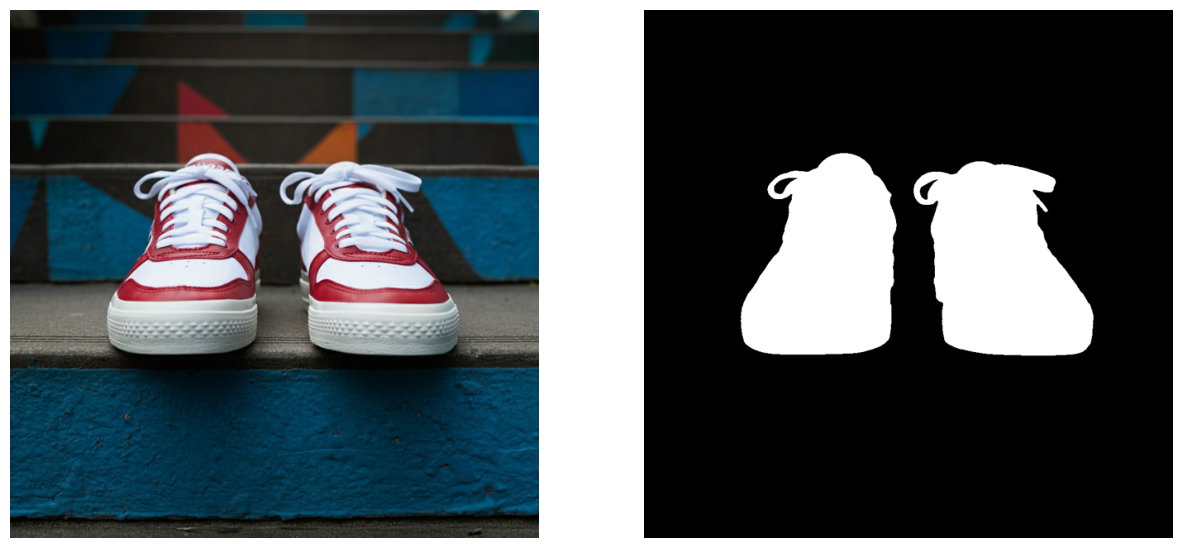

In [ ]:
image_bytes = ENCODED_IMAGE_BYTES  # Base64 encoded input image bytes
gcs_uri = None  # gs:// path to the input image
mime_type = None  # Image file type (JPEG, PNG, WEBP)
mode = "foreground"  # Segmentation mode [foreground,background,semantic,prompt,interactive]
prompt = None  # Prompt to guide segmentation for `semantic` and `prompt` modes
scribble_bytes = None  # Input scribble for `interactive` segment mode
mask_dilation = (
    None  # Optional mask dilation for thin objects. Numeric value between 0 and 1.
)
max_predictions = (
    None  # Optional maximum predictions limit for prompt mode. Unlimited by default.
)
confidence_threshold = (
    None  # Optional confidence limit for prompt/background/foreground modes.
)

response = call_vertex_image_segmentation(
    image_bytes,
    gcs_uri,
    mime_type,
    mode,
    prompt,
    scribble_bytes,
    mask_dilation,
    max_predictions,
    confidence_threshold,
)

MASK_PIL = prediction_to_mask_pil(response.predictions[0])
display_horizontally([INPUT_IMAGE_PIL, MASK_PIL], mask_index=1)

#### Background removal
Use the foreground segmentation mask you created above to make the image background transparent.

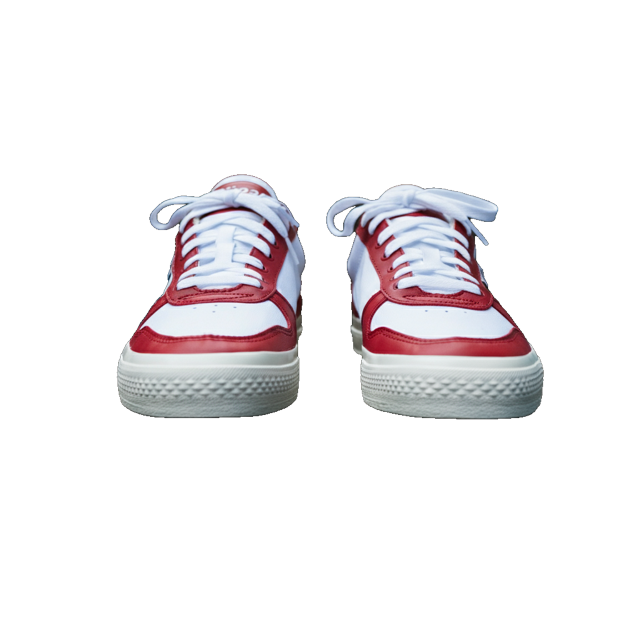

In [ ]:
# Creates an empty transparent background.
transparent_background = Image.new("RGBA", INPUT_IMAGE_PIL.size, (128, 128, 128, 255))

# Uses the mask to cut and paste the foreground object in the original image
# onto the transparent background.
transparent_background.paste(INPUT_IMAGE_PIL, mask=MASK_PIL)
transparent_background.putalpha(MASK_PIL)

display(transparent_background)

#### Change background color

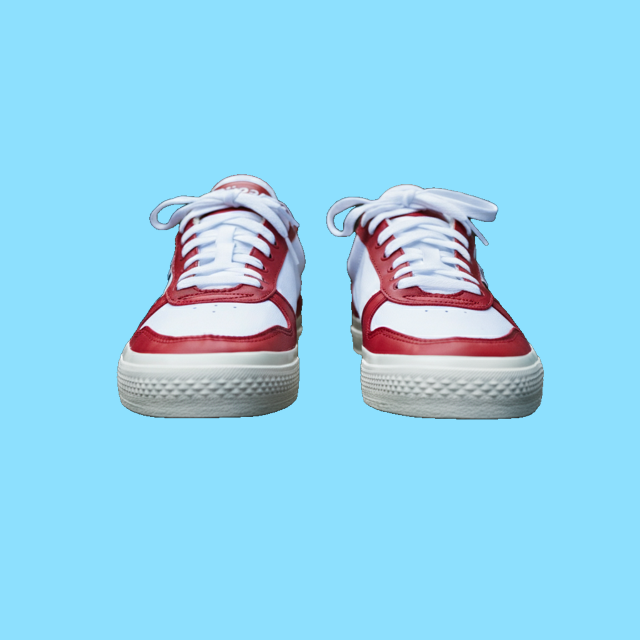

In [ ]:
# RGBA color light blue
color = (141, 224, 254, 255)
input_image = INPUT_IMAGE_PIL.copy()
gray_background = Image.new("RGBA", input_image.size, color)
gray_background.paste(input_image, mask=MASK_PIL)

display(gray_background)

### Background segment mode

Generate background masks.

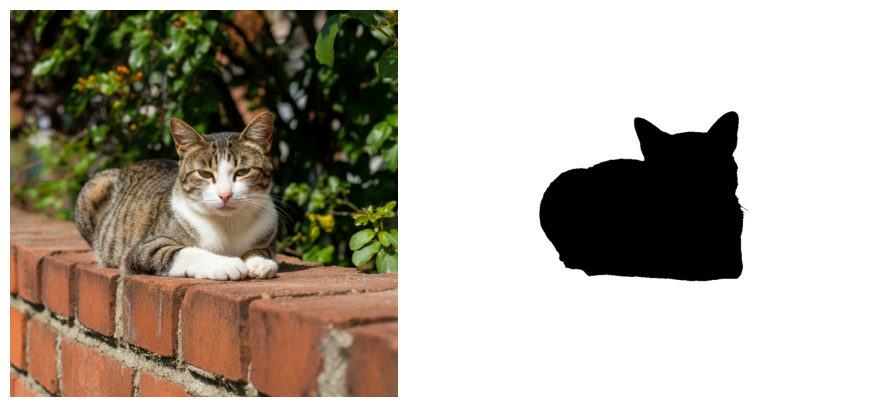

In [ ]:
response = call_vertex_image_segmentation(
    image_bytes=ENCODED_IMAGE_BYTES,
    gcs_uri=None,
    mime_type=None,
    mode="background",
    prompt=None,
    scribble_bytes=None,
    mask_dilation=None,
    max_predictions=None,
    confidence_threshold=None,
)

MASK_PIL = prediction_to_mask_pil(response.predictions[0])
display_horizontally([INPUT_IMAGE_PIL, MASK_PIL], mask_index=1)

### Semantic segment mode

Specify the objects to segment from the set of 194 classes. The full set is available in the Appendix section at the end of this tutorial. You can specify multiple classes by delimiting with commas, e.g. `prompt="cat, dog"`

The semantic segmenter will return a single prediction containing the generated mask. If the classes in the prompt are detected, they are masked in white pixels and the background will be black. If the requested classes are not detected in the image, the whole mask will be black.

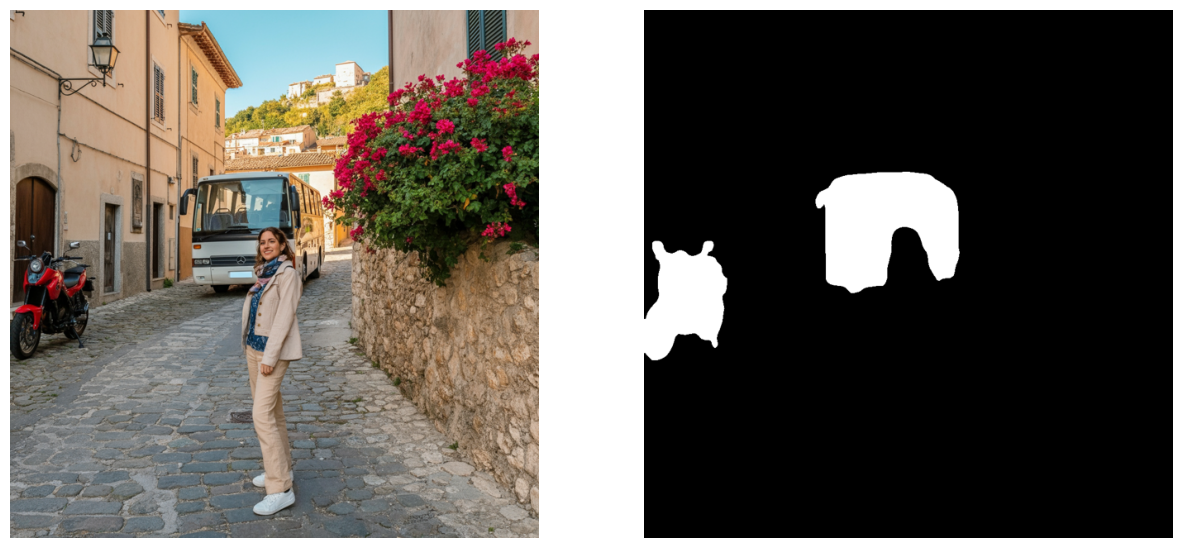

In [ ]:
mode = "semantic"
prompt = "motorcycle, bus"

response = call_vertex_image_segmentation(
    image_bytes=ENCODED_IMAGE_BYTES,
    gcs_uri=None,
    mime_type=None,
    mode=mode,
    prompt=prompt,
    scribble_bytes=None,
    mask_dilation=None,
    max_predictions=None,
    confidence_threshold=None,
)

MASK_PIL = prediction_to_mask_pil(response.predictions[0])
display_horizontally([INPUT_IMAGE_PIL, MASK_PIL], mask_index=1)

### Prompt instance segmentation mode

You can use Prompt mode to perform detection and segmentation on many instances of your suggested objects. The response can generate multiple masks, along with one or more associated labels for each mask. Each label also contains an confidence score. Only objects matching labels specified in the request prompt are detected and segmented. The prompt is completely open-vocabulary, it is not limited to any class set.

**Recommended**:
* Use the confidence_threshold and max_predictions parameters to filter and limit results
* You can request multiple items be detected by separating them with commas. Hundreds of classes can be set in a single prompt.

Vertex Image Segmentation took 1.66s.
Number of predictions is 59


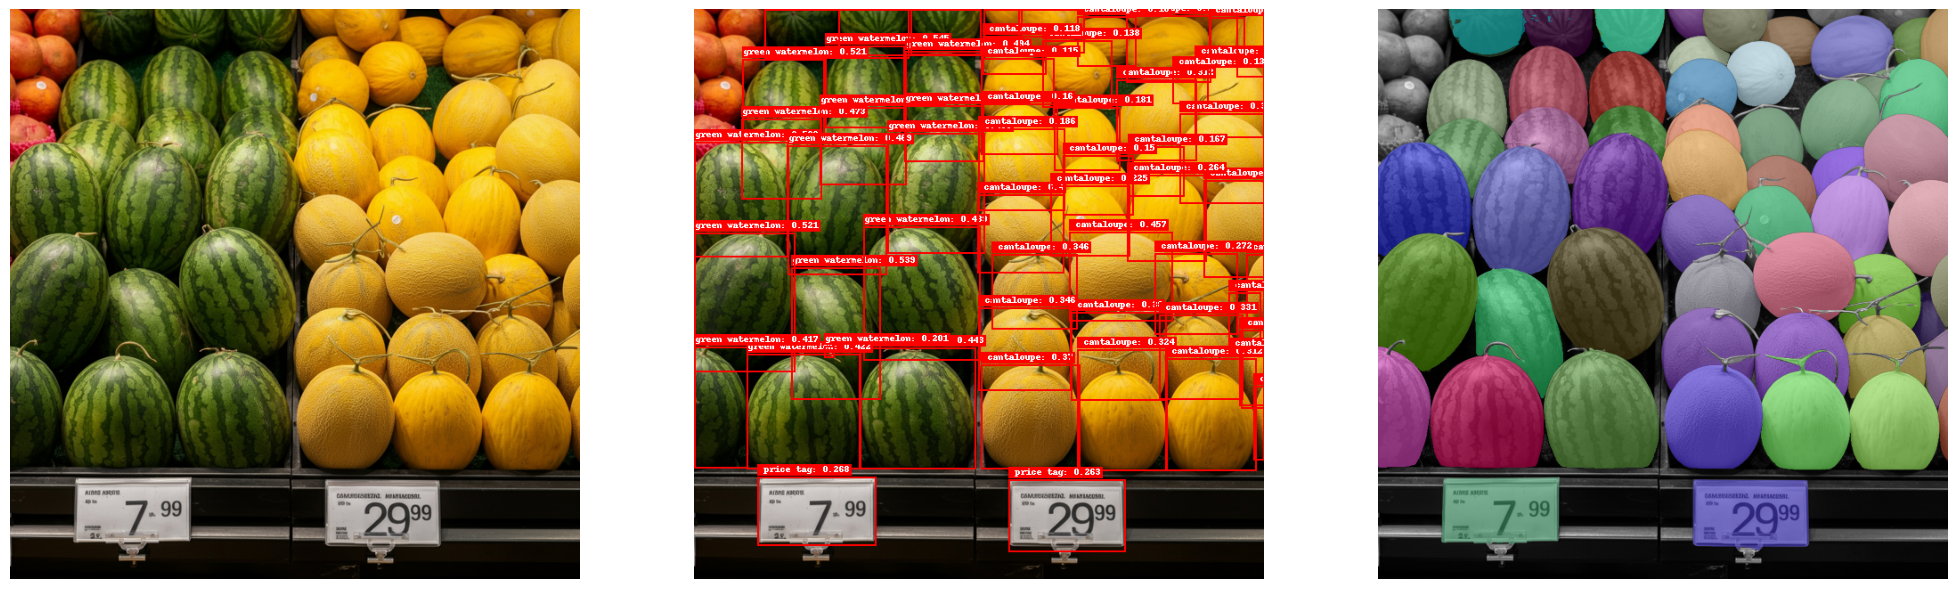

In [ ]:
mode = "prompt"
prompt = "green watermelon, cantaloupe, price tag"
confidence_threshold = 0.1
max_predictions = None

response = call_vertex_image_segmentation(
    image_bytes=ENCODED_IMAGE_BYTES,
    gcs_uri=None,
    mime_type=None,
    mode=mode,
    prompt=prompt,
    scribble_bytes=None,
    mask_dilation=None,
    max_predictions=max_predictions,
    confidence_threshold=confidence_threshold,
)

print(f"Number of predictions is {str(len(response.predictions))}")

bbox_image = draw_bounding_boxes(INPUT_IMAGE_PIL, response)
overlayed_image = overlay(INPUT_IMAGE_PIL, response)
display_horizontally([INPUT_IMAGE_PIL, bbox_image, overlayed_image], figsize=(25, 25))

### Interactive segment mode

Interactive segmentation enables point-to-mask or scribble-to-mask generation.
This mode is perfect for application developers.

1. Set the brush size
2. Run the canvas cell below to draw a mask to guide the interactive segmentation model.
3. Click and hold your mouse over the image and drag it to draw a mask, then let go. The scribble is saved automatically.
  * You can draw a single point to "select" an object to segment
  * A rough line over any object works as well
  * You can try scribbling over more of the desired object to see how the generated mask changes.
  * You can draw one or multiple scribbles.
5. When you're finished drawing, run the Segmentation cell


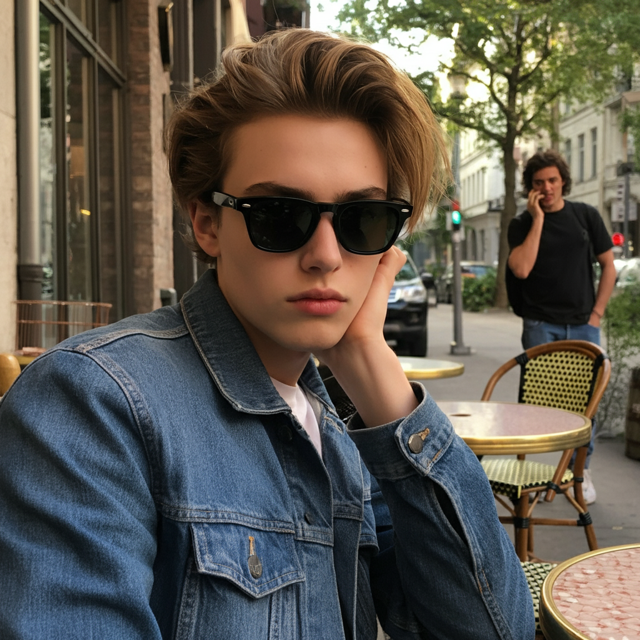

In [ ]:
# @title [Canvas] Draw a mask scribble
# @markdown Run this cell to begin drawing. Re-run this cell to start over.
brush_size = 15  # @param {type:"number"}

import base64
import re

from google.colab import html

code = """

export class MyCanvas extends HTMLElement {
  static get observedAttributes() {
    return ['src', 'aspect_ratio', 'brush_size'];
  }

  constructor() {
    super();
    var canvas = document.createElement("CANVAS");

    this.appendChild(canvas);
    this.canvas = canvas;
    this.context = canvas.getContext("2d");
    this.boundings = canvas.getBoundingClientRect();

    this.canvas.width = 512;
    this.canvas.height = 512;

    this.mouseX = 0;
    this.mouseY = 0;
    this.prevMouseX = 0;
    this.prevMouseY = 0;
    this.minLineLength = 0;

    this.context.strokeStyle = 'white';
    this.context.lineWidth = 20;
    this.context.lineCap = 'round';
    this.isDrawing = false;

    canvas.addEventListener('mousedown', function(event) {
      this.setMouseCoordinates(event);
      this.isDrawing = true;

      this.context.beginPath();
      this.context.moveTo(this.mouseX, this.mouseY);
    }.bind(this));

    canvas.addEventListener('mousemove', function(event) {
      this.setMouseCoordinates(event);

      if (this.isDrawing){
        this.context.lineTo(this.mouseX, this.mouseY);
        this.context.stroke();
      }
    }.bind(this));

    canvas.addEventListener('mouseup', function(event) {
      this.setMouseCoordinates(event);
      this.isDrawing = false;
    }.bind(this));
  }

  attributeChangedCallback(name, oldValue, newValue) {
    if (name == 'src') {
      this.canvas.style.backgroundImage = 'url(' + newValue +')';
      this.canvas.style.backgroundSize = '100%';
      this.canvas.style.imageRendering = 'pixelated';
    } else if (name == 'aspect_ratio') {
      this.canvas.width = this.canvas.height * newValue;
      this.context.strokeStyle = 'white';
      this.context.lineWidth = 50;
      this.context.lineCap = 'round';
    } else if (name == 'brush_size') {
      this.context.strokeStyle = 'white';
      this.context.lineWidth = newValue;
      this.context.lineCap = 'round';
    }
  }

  setMouseCoordinates(event) {
    this.prevMouseX = this.mouseX;
    this.prevMouseY = this.mouseY;
    this.mouseX = event.clientX - this.boundings.left;
    this.mouseY = event.clientY - this.boundings.top;
  }

  lineLengthTest() {
    var dist = Math.sqrt(
      Math.pow(this.mouseX - this.prevMouseX, 2) +
      Math.pow(this.mouseY - this.prevMouseY, 2));
    return dist > this.minLineLength;
  }

  getData() {
    return this.canvas.toDataURL();
  }

  setData(imageBytes) {
    const imageBlob = new Blob([imageBytes], { type: 'image/png' }); // Assuming PNG format
    const imageUrl = URL.createObjectURL(imageBlob);

    const img = new Image();
    img.onload = () => {
      this.canvas.width = img.width;
      this.canvas.height = img.height;
      this.context.drawImage(img, 0, 0);

      URL.revokeObjectURL(imageUrl); // Clean up
    };
    img.src = imageUrl;
  }

}
customElements.define('my-canvas', MyCanvas);
"""
script = html.create_resource(code, extension="js")


def get_image_url(np_image):
    img = Image.fromarray(np_image)
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    return "data:image/png;base64," + base64.b64encode(buf.getvalue()).decode("utf-8")


class Canvas(html.Element):
    def __init__(self, image, brush_size=20):
        super(Canvas, self).__init__("my-canvas", src={"module": script.url})
        self.set_attribute("src", get_image_url(image))
        height, width = image.shape[0:2]
        self.set_attribute("aspect_ratio", str(width / height))
        self.set_attribute("brush_size", str(brush_size))

    def get_data(self):
        data = self.call("getData")
        data = base64.b64decode(re.sub("^data:image/.+;base64,", "", data))
        image = Image.open(io.BytesIO(data))
        return image

    def set_data_from_image_bytes(self, image_bytes):
        self.call("setData", image_bytes)


# Extracts the scribble from the canvas and converts it to encoded image bytes.
def get_scribble_from_canvas(canvas: Canvas) -> str:
    mask_pil = canvas.get_data()
    mask_np = np.array(mask_pil)
    mask_np.shape, mask_np.dtype

    # The scribble input should be a binary color image where white pixels
    # represent the scribble brush stroke.
    mask_bin_np = (((mask_np / 255) > 0.5) * 255).astype(np.uint8)
    mask_bin_pil = Image.fromarray(mask_bin_np).convert("RGB")
    mask_bin_bytes = io.BytesIO()

    # The scribble should be a PNG for maximum quality.
    mask_bin_pil.save(mask_bin_bytes, format="PNG")
    encoded_scribble_bytes = base64.b64encode(mask_bin_bytes.getvalue()).decode("utf-8")
    return encoded_scribble_bytes


canvas = Canvas(np.array(INPUT_IMAGE_PIL), brush_size=brush_size)
canvas

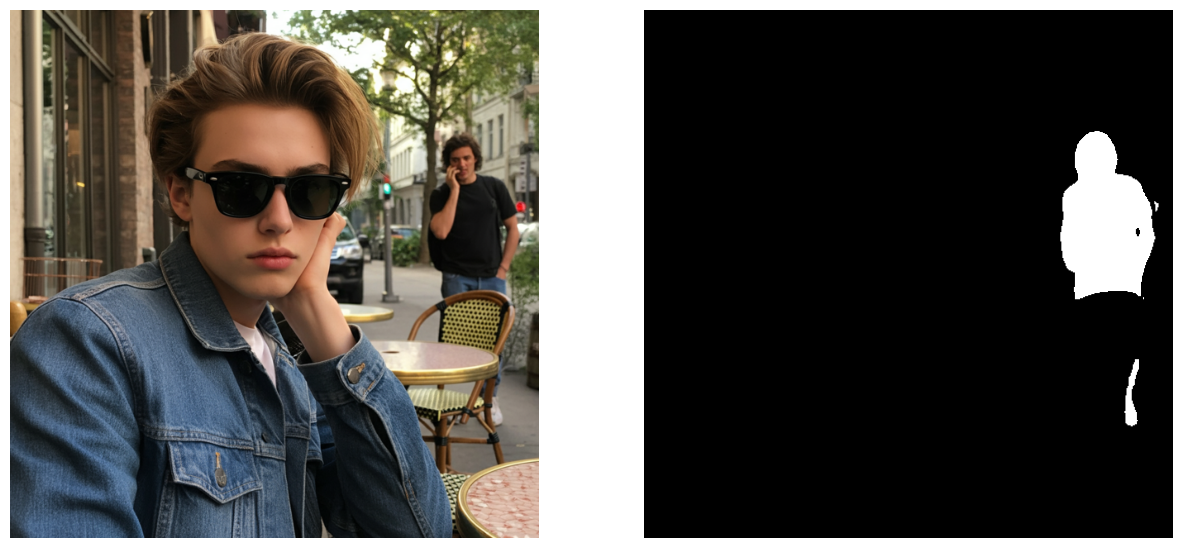

In [ ]:
# Segment the input image using the scribble drawn in the cell above.
# Input scribble for `interactive` segment mode
scribble_bytes = get_scribble_from_canvas(canvas)

response = call_vertex_image_segmentation(
    image_bytes=ENCODED_IMAGE_BYTES,
    gcs_uri=None,
    mime_type=None,
    mode="interactive",
    prompt=None,
    scribble_bytes=scribble_bytes,
    mask_dilation=None,
    max_predictions=None,
    confidence_threshold=None,
)

MASK_PIL = prediction_to_mask_pil(response.predictions[0])
display_horizontally([INPUT_IMAGE_PIL, MASK_PIL], mask_index=1)

## Conclusion

You have explored the Vertex AI's Image Segmentation service and its features.

Check out the Vertex AI reference to learn more about how to [Segment images](https://cloud.google.com/vertex-ai/generative-ai/docs/image/img-gen-prompt-guide#edit-prompts).

## Appendix

### Semantic segmentation classes

| Class ID | Class ID | Class ID | Class ID |
| --- | --- | --- | --- |
|   backpack  |   broccoli  |   road  |   mountain_hill   |
|   umbrella  |   carrot  |   snow  |   rock    |
|   bag |   hot_dog |   sidewalk_pavement |   frisbee   |
|   tie |   pizza |   runway  |   skis    |
|   suitcase  |   donut |   terrain |   snowboard   |
|   case  |   cake  |   book  |   sports_ball   |
|   bird  |   fruit_other |   box |   kite    |
|   cat |   food_other  |   clock |   baseball_bat    |
|   dog |   chair_other |   vase  |   baseball_glove    |
|   horse |   armchair  |   scissors  |   skateboard    |
|   sheep |   swivel_chair  |   plaything_other |   surfboard   |
|   cow |   stool |   teddy_bear  |   tennis_racket   |
|   elephant  |   seat  |   hair_dryer  |   net   |
|   bear  |   couch |   toothbrush  |   base    |
|   zebra |   trash_can |   painting  |   sculpture   |
|   giraffe |   potted_plant  |   poster  |   column    |
|   animal_other  |   nightstand  |   bulletin_board  |   fountain    |
|   microwave |   bed |   bottle  |   awning    |
|   radiator  |   table |   cup |   apparel   |
|   oven  |   pool_table  |   wine_glass  |   banner    |
|   toaster |   barrel  |   knife |   flag    |
|   storage_tank  |   desk  |   fork  |   blanket   |
|   conveyor_belt |   ottoman |   spoon |   curtain_other   |
|   sink  |   wardrobe  |   bowl  |   shower_curtain    |
|   refrigerator  |   crib  |   tray  |   pillow    |
|   washer_dryer  |   basket  |   range_hood  |   towel   |
|   fan |   chest_of_drawers  |   plate |   rug_floormat    |
|   dishwasher  |   bookshelf |   person  |   vegetation    |
|   toilet  |   counter_other |   rider_other |   bicycle   |
|   bathtub |   bathroom_counter  |   bicyclist |   car   |
|   shower  |   kitchen_island  |   motorcyclist  |   autorickshaw    |
|   tunnel  |   door  |   paper |   motorcycle    |
|   bridge  |   light_other |   streetlight |   airplane    |
|   pier_wharf  |   lamp  |   road_barrier  |   bus   |
|   tent  |   sconce  |   mailbox |   train   |
|   building  |   chandelier  |   cctv_camera |   truck   |
|   ceiling |   mirror  |   junction_box  |   trailer   |
|   laptop  |   whiteboard  |   traffic_sign  |   boat_ship   |
|   keyboard  |   shelf |   traffic_light |   slow_wheeled_object   |
|   mouse |   stairs  |   fire_hydrant  |   river_lake    |
|   remote  |   escalator |   parking_meter |   sea   |
|   cell phone  |   cabinet |   bench |   water_other   |
|   television  |   fireplace |   bike_rack |   swimming_pool   |
|   floor |   stove |   billboard |   waterfall   |
|   stage |   arcade_machine  |   sky |   wall    |
|   banana  |   gravel  |   pole  |   window    |
|   apple |   platform  |   fence |   window_blind    |
|   sandwich  |   playingfield  |   railing_banister  |       |
|   orange  |   railroad  |   guard_rail  |       |
